# <div style="text-align: center; color: cyan">Model and Transfer Learning</div>

## <div style="text-align: center; color: lime">Setup</div>

In [1]:
import os

os.environ["KERAS_BACKEND"] = "torch"

## <div style="text-align: center; color: lime">Imports</div>

In [2]:
from pathlib import Path

from matplotlib import pyplot as plt

import torch
from torch.utils.data import random_split, DataLoader

from torchvision.datasets import ImageFolder
from torchvision import transforms

import keras
from keras import layers

import kagglehub


## <div style="text-align: center; color: lime">Load the data</div>

In [3]:
path = kagglehub.dataset_download("balabaskar/tom-and-jerry-image-classification")

data_path = Path(path) / "tom_and_jerry/tom_and_jerry"

trs = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]
)

all_data = ImageFolder(data_path, transform=trs)

g1 = torch.Generator().manual_seed(20)
train_data, val_data, test_data = random_split(all_data, [0.7, 0.2, 0.1], g1)

train_loader = DataLoader(train_data, batch_size=12, shuffle=True)
val_loader = DataLoader(val_data, batch_size=12, shuffle=False)
test_loader = DataLoader(test_data, batch_size=12, shuffle=False)


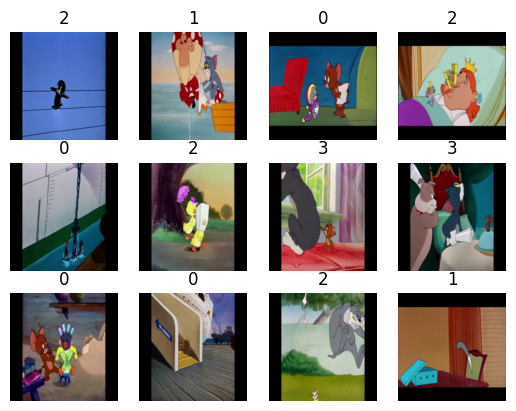

In [4]:
fig, axes = plt.subplots(3, 4)

axes_ravel = axes.ravel()

for images, labels in train_loader:
    for i, (image, label) in enumerate(zip(images, labels)):
        axes_ravel[i].imshow(transforms.ToPILImage()(image))
        axes_ravel[i].set_axis_off()
        axes_ravel[i].set_title(f"{label}")
    break

## <div style="text-align: center; color: lime">Keras Sequential</div>

In [24]:
keras.Sequential(
    [
    ],
)

<Sequential name=sequential_4, built=False>

## <div style="text-align: center; color: lime">Input Layer</div>

In [25]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(3, 224, 224)),
    ],
)

## <div style="text-align: center; color: lime">Output Layer</div>

In [26]:
model = keras.Sequential(
    [
        keras.layers.Input(shape=(3, 224, 224)),
        keras.layers.Dense(4, activation="softmax"),
    ],
)


## <div style="text-align: center; color: lime">Flatten</div>

In [27]:
model = keras.Sequential(
    [
        layers.Input(shape=(3, 224, 224)),
        layers.Flatten(),
        layers.Dense(4, activation="softmax"),
    ]
)

## <div style="text-align: center; color: lime">Compile</div>

In [9]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       602,116 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 602,116 (2.30 MB)

 Trainable params: 602,116 (2.30 MB)

 Non-trainable params: 0 (0.00 B)

None


In [6]:
for images, labels in train_loader:
    result = model(images)
    print(result.shape)
    break


torch.Size([12, 4])


## <div style="text-align: center; color: lime">fit</div>

## <div style="text-align: center; color: lime">Evaluate</div>

## <div style="text-align: center; color: lime">Transfer Learning</div>

### <div style="text-align: center; color: lightsalmon">Keras Applications</div>

In [10]:
base_model = keras.applications.MobileNetV2(include_top=False, input_shape=(224, 224, 3))

base_model.trainable = False

### <div style="text-align: center; color: lightsalmon">Permute layer</div>

In [14]:
p = layers.Permute((2, 3, 1))

In [16]:
p(images).shape

torch.Size([12, 224, 224, 3])

In [17]:
model = keras.Sequential(
    [
        layers.Input(shape=(3, 224, 224)),
        layers.Permute((2, 3, 1)),
        base_model,
        layers.Flatten(),
        layers.Dense(4, activation="softmax"),
    ]
)

model.compile(
    optimizer="adam",
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [18]:
print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ permute_1 (Permute)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │       250,884 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,508,868 (9.57 MB)

 Trainable params: 250,884 (980.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

None


In [20]:
history = model.fit(train_loader, epochs=10, validation_data=[val_loader])

Epoch 1/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 38s 119ms/step - accuracy: 0.4183 - loss: 9.2435 - val_accuracy: 0.4608 - val_loss: 8.5584
Epoch 2/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.4881 - loss: 8.0952 - val_accuracy: 0.3467 - val_loss: 10.2045
Epoch 3/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 47s 146ms/step - accuracy: 0.5137 - loss: 7.7138 - val_accuracy: 0.5292 - val_loss: 7.5211
Epoch 4/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 44s 137ms/step - accuracy: 0.5505 - loss: 7.1557 - val_accuracy: 0.5356 - val_loss: 7.3388
Epoch 5/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 42s 130ms/step - accuracy: 0.5565 - loss: 7.0391 - val_accuracy: 0.5328 - val_loss: 7.3272
Epoch 6/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 41s 129ms/step - accuracy: 0.5778 - loss: 6.7200 - val_accuracy: 0.5511 - val_loss: 7.1559
Epoch 7/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.5880 - loss: 6.5801 - val_accuracy: 0.5484 - val_loss: 7.2219
Epoch 8/10
320/320 ━━━━━━━━━━━━━━━━━━━━ 40s 125ms/step - accuracy: 0.5851 - loss: 

In [21]:
model.evaluate(test_loader)

46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.5411 - loss: 7.3069


[7.306948184967041, 0.541133463382721]

<p style="text-align: center; font-family: "Trebuchet MS", sans-serif; color: #888; font-size: 0.9em; margin-top: 2em; border-top: 1px solid #ccc; padding-top: 0.5em;">
    @LiterallyTheOne — PhD Candidate in Artificial Intelligence
</p>

<div style="text-align: center">
<a style="margin: 1em" href="https://literallytheone.github.io">https://literallytheone.github.io</a>
</div>
